In [ ]:
# https://github.com/microsoft/CameraTraps/blob/main/data_management/lila/create_lila_test_set.py
# https://github.com/cindyweng/coco-to-yolo-by-category/blob/5fcd1ae51af89c1c678d903a4aff5d32cba25b0b/coco-to-yolo-by-category.py#L41

In [177]:
import json
import random
import numpy as np
import shutil
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from operator import itemgetter 
from itertools import groupby
from os.path import exists
import seaborn as sns
import pandas as pd
from urllib.parse import urlparse


random.seed(42)

In [151]:
basepath = './data/swg/images/images/' # refactor to match path naming
metadata_path_no_bbox = './data\SWG\swg_camera_traps\swg_camera_traps.json'
metadata_path = './data\SWG\swg_camera_traps.bounding_boxes.with_species\swg_camera_traps.bounding_boxes.with_species.json'
# train_path = './data/ultralytics/images/train/'
# val_path = './data/ultralytics/images/val/'
# test_path = './data/ultralytics/images/test/'
# label_path = './data/ultralytics/labels/'

In [152]:
with open(metadata_path) as f:
    d = json.load(f)
# with open(metadata_path_no_bbox) as f:
#     dnb = json.load(f)

In [153]:
for i in range(len(d['images'])):
    d['images'][i]['image_id'] = d['images'][i].pop('id')

my_id = itemgetter('image_id')
meta_anno = []

for k, v in groupby(sorted((d['annotations'] + d['images']), key=my_id), key=my_id):
    meta_anno.append({key:val for d in v for key, val in d.items()})

In [154]:
private_ids = set()
for idx, image in enumerate(meta_anno):
    if 'private' in image['file_name']:
        private_ids.add(image['image_id'])
print('number of private ids: {}'.format(len(private_ids)))
meta_anno = [img for img in meta_anno if img.get('image_id') not in private_ids]


number of private ids: 1039


In [155]:
corrupt_ids = set()
for idx, image in enumerate(meta_anno):
    if image['corrupt']:
        corrupt_ids.add(image['image_id'])
meta_anno = [img for img in meta_anno if img.get('image_id') not in corrupt_ids]
print('number of corrupt ids: {}'.format(len(corrupt_ids)))

number of corrupt ids: 0


In [156]:
category_remove_ids = set()
for idx, image in enumerate(meta_anno):
    try:
        if image['category_id'] in (1,2): # tags 'ignore' and 'blurred' removed.
            category_remove_ids.add(image['image_id'])
    except KeyError: 
            category_remove_ids.add(image['image_id'])
meta_anno = [img for img in meta_anno if img.get('image_id') not in category_remove_ids]
print('number of images removed based on cats and keyerror: {}'.format(len(category_remove_ids)))

number of images removed based on cats and keyerror: 8


In [157]:
location_counter = {}
sequence_counter = {}
species_counter = {}

for img in meta_anno:
    location_counter[img.get('location')] = location_counter.get(img.get('location'), 0) + 1
    sequence_counter[img.get('seq_num_frames')] = sequence_counter.get(img.get('seq_num_frames'), 0) + 1
    species_counter[img.get('category_id')] = species_counter.get(img.get('category_id'), 0) + 1

species_lookup = {i.get('id') : i.get('name') for i in d['categories']}
species_named_counter = {species_lookup.get(k): v for k, v in species_counter.items()}

In [158]:
# https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

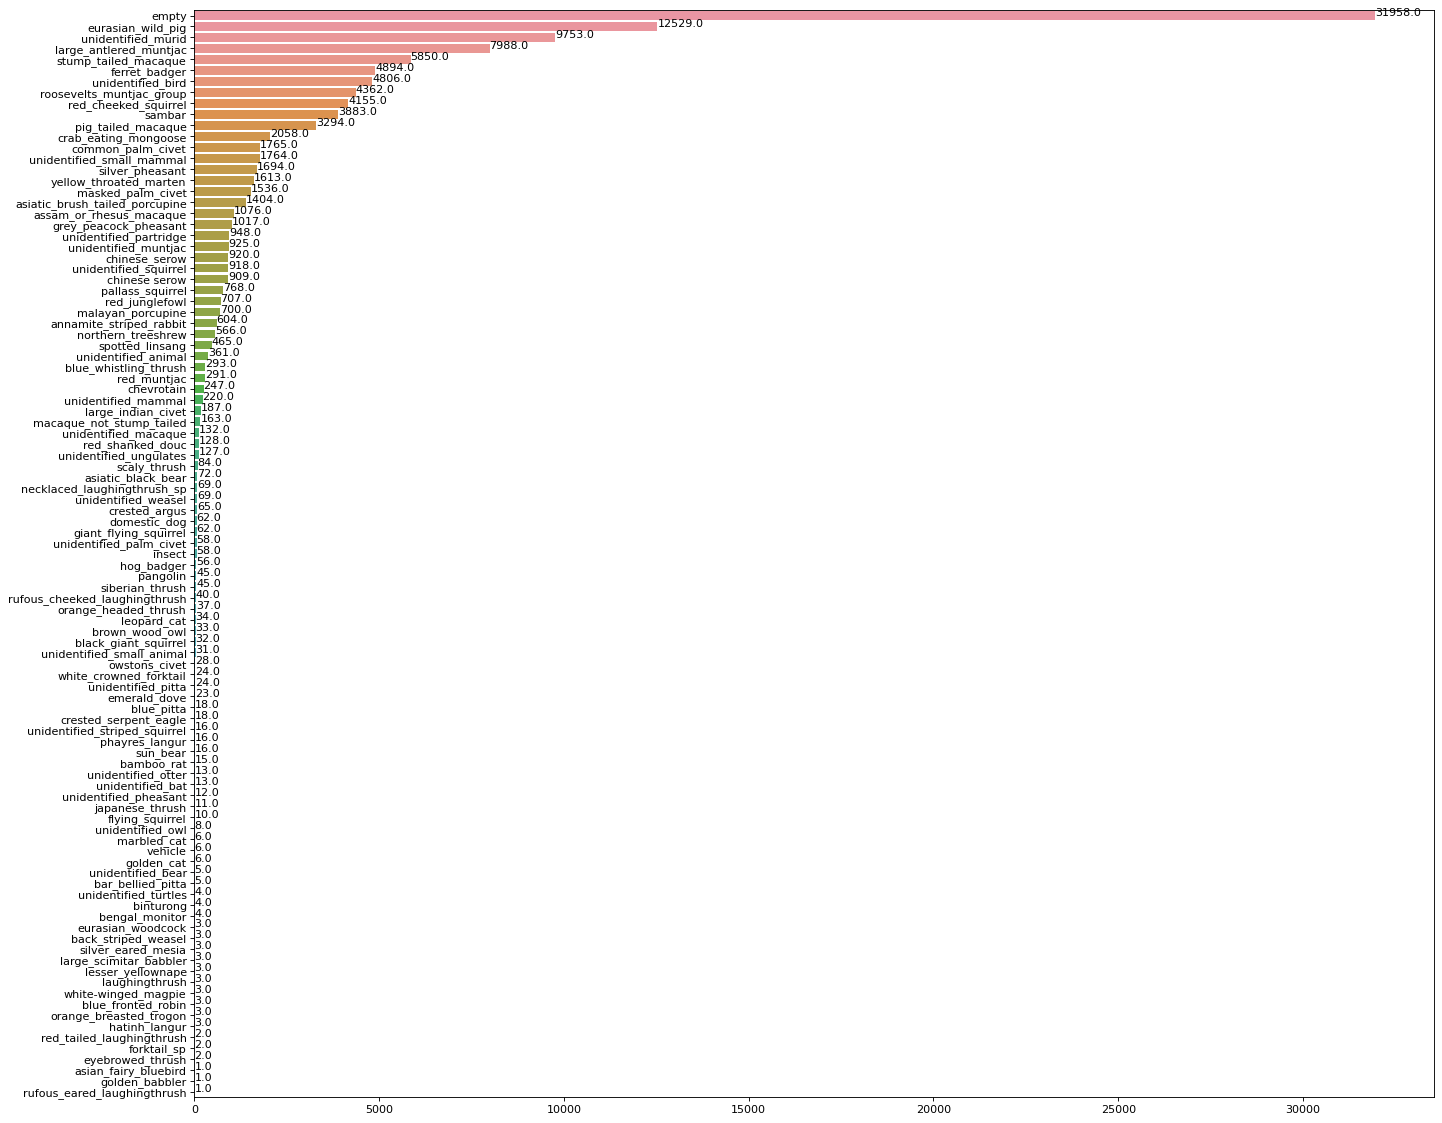

In [162]:
figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='r')
y = list(species_named_counter.keys())
x = list(species_named_counter.values())
argx = np.argsort(x)[::-1]
x = np.array(x)[argx]
y = np.array(y)[argx]
p = sns.barplot(x = x, y = y)
show_values(p, "h", space=0)
plt.show()

array([99, 97, 91, 87, 93, 98, 95, 25, 96, 86, 71, 37, 36, 33, 94, 21, 62,
       57, 72, 73, 41, 65, 77, 79, 24, 70, 89, 26, 40, 50, 74, 61, 76, 67,
       64, 92, 17, 54, 20, 30, 80, 82, 63, 84, 56, 27, 38, 58, 90, 53, 68,
       29, 78, 52, 55, 59, 83, 66, 31, 14, 69, 46, 81, 23, 28, 42, 75, 88,
       39, 49, 60, 34, 44, 45, 51, 85, 35, 48, 11, 12, 43, 47, 22, 18, 32,
        5, 13,  4, 19,  7, 16,  8,  9, 10,  0,  1,  6, 15,  3,  2])

In [165]:
def gen_dataset(d, remove_missing_id, n_empty= 1000, n_nempty=1000):
    n_empty_images_per_dataset = n_empty
    n_non_empty_images_per_dataset = n_nempty

    category_id_to_name = {c['id']:c['name'] for c in d['categories']}
    category_name_to_id = {c['name']:c['id'] for c in d['categories']}


    human_category_id = category_name_to_id['human'] if 'human' in category_name_to_id.keys() else -1 # filter out humans


    if 'empty' not in category_name_to_id:
        print('Warning: no empty images available for {}'.format('dataset'))
        empty_category_id = -1
        empty_annotations = []
        empty_annotations_to_download = []
    else:
        empty_category_id = category_name_to_id['empty']        
        empty_annotations = [ann for ann in d['annotations'] if ann['category_id'] == empty_category_id and ann['image_id'] not in remove_missing_id]
        empty_annotations_to_download = random.sample(empty_annotations, n_empty_images_per_dataset)        
        
    non_empty_annotations = [ann for ann in d['annotations'] if ann['category_id'] not in (empty_category_id, human_category_id) and ann['image_id'] not in remove_missing_id]

    non_empty_annotations_to_download = random.sample(non_empty_annotations, n_non_empty_images_per_dataset)
    annotations_to_download = empty_annotations_to_download + non_empty_annotations_to_download
    image_ids_to_download = set([ann['image_id'] for ann in annotations_to_download])
    assert len(image_ids_to_download) == len(set(image_ids_to_download))

    images_to_download = []
    for im in d['images']:
        if im['image_id'] in image_ids_to_download:
            images_to_download.append(im)
    assert len(images_to_download) == len(image_ids_to_download)
    
    return images_to_download

In [181]:
images_to_download = gen_dataset(d, [-1], 10, 10)
train, validate, test = np.split(images_to_download, [int(.8*len(images_to_download)), int(.9*len(images_to_download))])

In [182]:
base_url = "https://lilablobssc.blob.core.windows.net/swg-camera-traps/"
downloader = {'sas_url': 'https://lilablobssc.blob.core.windows.net/swg-camera-traps',
                'filenames' : [] }

In [183]:
dataset = train
urls_to_download = []
for im in dataset:
    dname = f'{dataset=}'.split('=')[0]
    filenames = [im['file_name'] for im in dataset] # if im['id'] in image_ids_of_interest]
        # Convert to URLs
    # for fn in filenames:        
    #     url = base_url + '/' + fn
    #     urls_to_download.append(url)

    downloader['filenames'] = filenames

#

In [185]:
lila_local_base = r'c:\temp\lila'

output_dir = os.path.join(lila_local_base,'lila_downloads_by_species')
os.makedirs(output_dir,exist_ok=True)

metadata_dir = os.path.join(lila_local_base,'metadata')
os.makedirs(metadata_dir,exist_ok=True)

In [194]:
sas_url = downloader['sas_url']
filenames = downloader['filenames']

# We want to use the whole relative path for this script (relative to the base of the container)
# to build the output filename, to make sure that different data sets end up in different folders.

# This may or may not be a SAS URL
if '?' in sas_url:
    base_url = sas_url.split('?')[0]        
    sas_token = sas_url.split('?')[1]
    assert not sas_token.startswith('?')
else:
    sas_token = ''
    base_url = sas_url
    
assert not base_url.endswith('/')

p = urlparse(base_url)
account_path = p.scheme + '://' + p.netloc
assert account_path == 'https://lilablobssc.blob.core.windows.net'

container_and_folder = p.path[1:]


In [195]:
filenames

['public/lao/loc_0051/2018/04/image_00523.jpg',
 'public/lao/loc_0058/2018/03/image_00020.jpg',
 'public/lao/loc_0052/2017/12/image_00154.jpg',
 'public/lao/loc_0369/2020/04/image_00133.jpg',
 'public/lao/loc_0376/2020/07/image_00247.jpg',
 'public/lao/loc_0393/2020/06/image_00274.jpg',
 'public/lao/loc_0427/2020/05/image_00245.jpg',
 'public/lao/loc_0475/2020/05/image_00008.jpg',
 'public/lao/loc_0553/2020/04/image_00220.jpg',
 'public/lao/loc_0171/2018/09/image_00120.jpg',
 'public/lao/loc_0253/2019/08/image_00068.jpg',
 'public/lao/loc_0154/2019/03/image_00184.jpg',
 'public/lao/loc_0262/2019/03/image_00504.jpg',
 'public/lao/loc_0588/2020/02/image_00437.jpg',
 'public/lao/loc_0612/2020/02/image_00040.jpg',
 'public/lao/loc_0614/2020/03/image_00110.jpg']

In [190]:
container_and_folder

'swg-camera-traps'

In [196]:
if len(container_and_folder.split('/')) == 2:
    container_name = container_and_folder.split('/')[0]
    folder = container_and_folder.split('/',1)[1]
    filenames = [folder + '/' + s for s in filenames]
else: 
    assert(len(container_and_folder.split('/')) == 1)
    container_name = container_and_folder
    filenames = ['/' + s for s in filenames]

container_sas_url = account_path + '/' + container_name
if len(sas_token) > 0:
    container_sas_url += '?' + sas_token

# The container name will be included because it's part of the file name
container_output_dir = output_dir # os.path.join(output_dir,container_name)


1

In [203]:
assert("a".split('/')[0])

In [197]:
container_output_dir

'c:\\temp\\lila\\lila_downloads_by_species'

In [ ]:
os.makedirs(container_output_dir,exist_ok=True)

# Write out a list of files, and use the azcopy "list-of-files" option to download those files
# this azcopy feature is unofficially documented at https://github.com/Azure/azure-storage-azcopy/wiki/Listing-specific-files-to-transfer
az_filename = os.path.join(output_dir, 'filenames_{}.txt'.format('TRAIN'.lower().replace(' ','_')))
with open(az_filename, 'w') as f:
    for fn in filenames:
        f.write(fn.replace('\\','/') + '\n')
        
cmd = 'azcopy cp "{0}" "{1}" --list-of-files "{2}"'.format(
        container_sas_url, container_output_dir, az_filename)            

# import clipboard; clipboard.copy(cmd)

os.system(cmd)


In [167]:
# TODO YAML file + automated downloading

array([{'datetime': '2018-02-28 03:07:12+00:00', 'file_name': 'public/lao/loc_0002/2018/02/image_00049.jpg', 'seq_id': 'e2275a6c-8c29-11eb-88e3-000d3a74c7de', 'frame_num': 1, 'seq_num_frames': 6, 'location': 'loc_0002', 'width': 3264, 'height': 2448, 'corrupt': False, 'image_id': 'c7ba546b-8c29-11eb-adc7-000d3a74c7de'},
       {'datetime': '2017-10-08 12:53:22+00:00', 'file_name': 'public/lao/loc_0000/2017/10/image_00010.jpg', 'seq_id': '0a9bb76a-8c2a-11eb-966d-000d3a74c7de', 'frame_num': 1, 'seq_num_frames': 12, 'location': 'loc_0000', 'width': 3264, 'height': 2448, 'corrupt': False, 'image_id': 'c7a2835d-8c29-11eb-b0b7-000d3a74c7de'},
       {'datetime': '2017-09-28 07:10:56+00:00', 'file_name': 'public/lao/loc_0000/2017/09/image_00016.jpg', 'seq_id': '0a9bb765-8c2a-11eb-bf49-000d3a74c7de', 'frame_num': 1, 'seq_num_frames': 3, 'location': 'loc_0000', 'width': 3264, 'height': 2448, 'corrupt': False, 'image_id': 'c7a28342-8c29-11eb-a1bc-000d3a74c7de'},
       ...,
       {'datetime': '